# Import libraries

In [1]:
!pip install pandas_ta
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=7562f5a5df64c744091d6850ec845852be3a138b47380bdc4bb5b07786faa2d5
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas_ta as ta
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import random
from copy import deepcopy
from torch.optim import Adam
from torch.nn import MSELoss
import copy

## Nasdaq

### Data Insights

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Nasdaq = pd.read_csv('/content/drive/MyDrive/ML_project/Data/Nasdaq_weekly.csv')

In [ ]:
Nasdaq.head()

,Date,Open,High,Low,Close,Volume
0,1994-03-06,785.62,793.60,771.88,790.55,0
1,1994-03-13,792.06,795.84,786.23,789.20,0
2,1994-03-20,790.02,804.53,789.16,803.93,0
3,1994-03-27,803.39,804.01,783.13,783.45,0
4,1994-04-03,784.21,784.79,731.74,743.46,0


In [ ]:
Nasdaq.isnull().sum()

Date      0
Open      2
High      2
Low       2
Close     2
Volume    0
dtype: int64

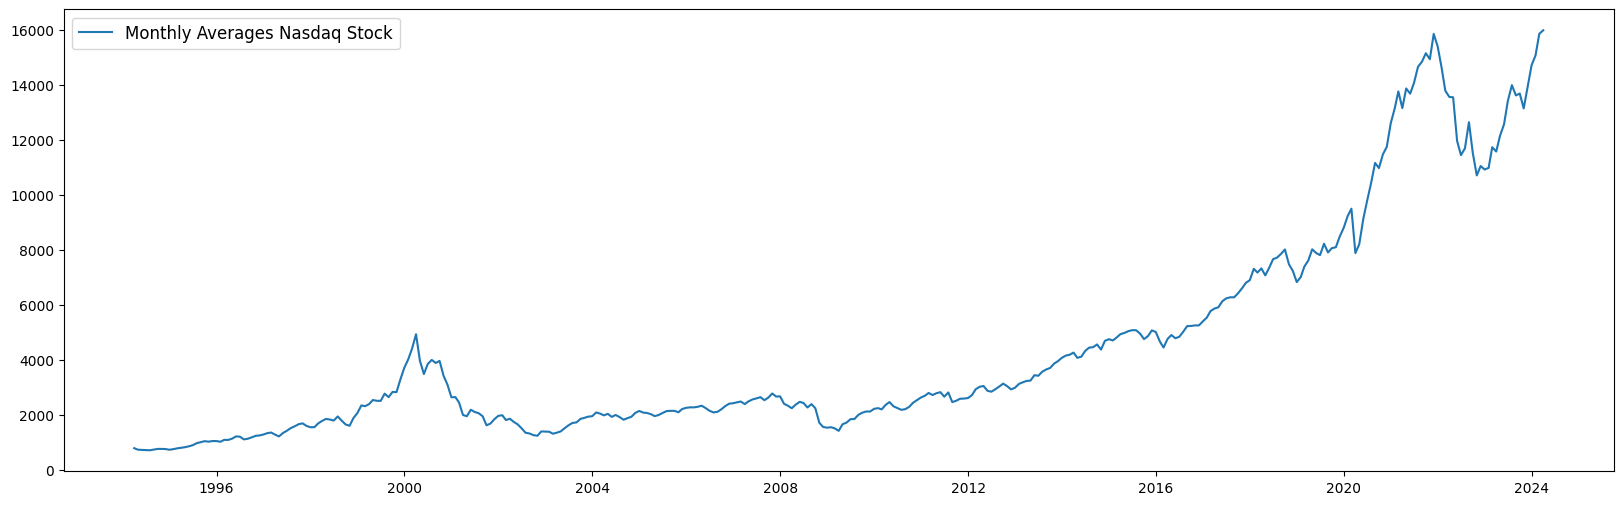

In [ ]:
Nasdaq['Date'] = pd.to_datetime(Nasdaq.Date)
newNasdaq = Nasdaq.set_index('Date')
# Resample the data to the monthly level
monthly_data = newNasdaq[['Close', 'Open', 'High', 'Low', 'Volume']].resample('M').mean()
##Monthly Stock Price
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['Close'],label='Monthly Averages Nasdaq Stock')
plt.legend(prop={'size': 12})
plt.show()

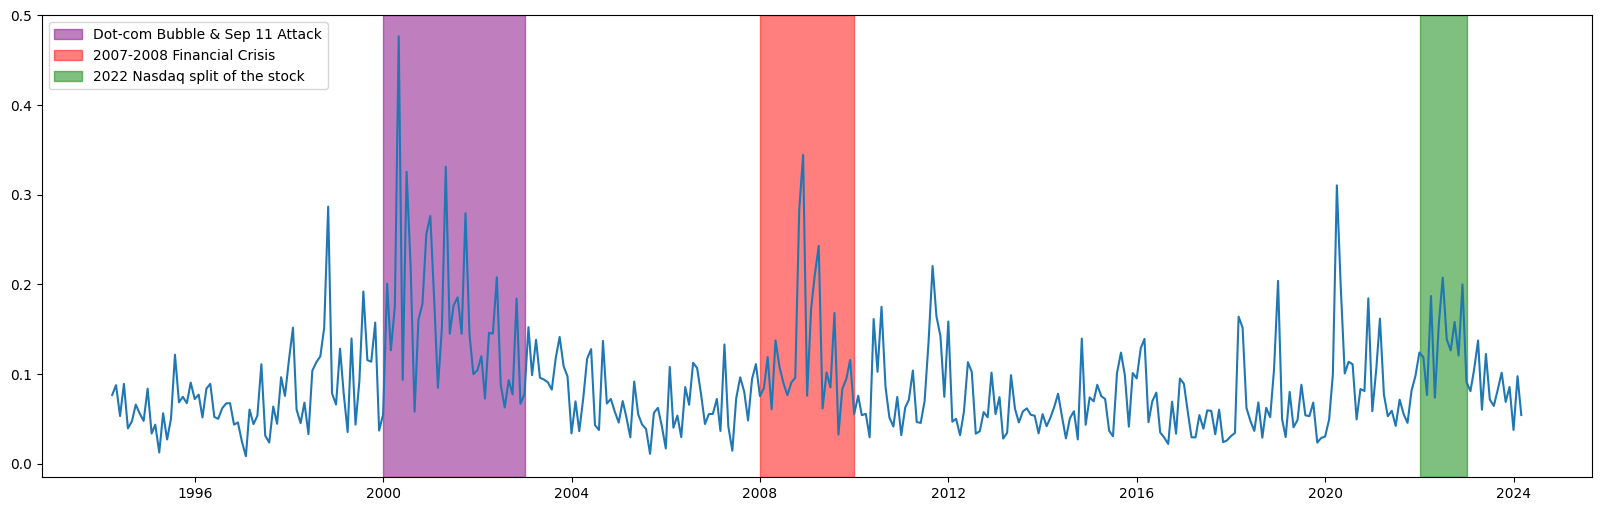

In [ ]:
# Calculate weekly returns using percentage change
weekly_returns = newNasdaq['Close'].pct_change()
weekly_returns.dropna(inplace=True)

# Resample to monthly data and calculate the standard deviation as a measure of volatility
# Then annualize the monthly volatility
monthly_volatility = weekly_returns.resample("M").std() * np.sqrt(12)

# Visualize major market events reflected in volatility
plt.figure(figsize=(20, 6))
plt.plot(monthly_volatility)
plt.axvspan('2000', '2003', color='purple', alpha=.5)
plt.axvspan('2008', '2010', color='red', alpha=.5)
plt.axvspan('2022', '2023', color='green', alpha=.5)
#plt.title("Monthly Annualized Volatility")

# Add legend for major market events
l1 = mpatches.Patch(color='purple', alpha=.5, label="Dot-com Bubble & Sep 11 Attack")
l2 = mpatches.Patch(color='red', alpha=.5, label="2007-2008 Financial Crisis")
l3 = mpatches.Patch(color='green', alpha=.5, label="2022 Nasdaq split of the stock")
plt.legend(handles=[l1, l2, l3])

plt.show()

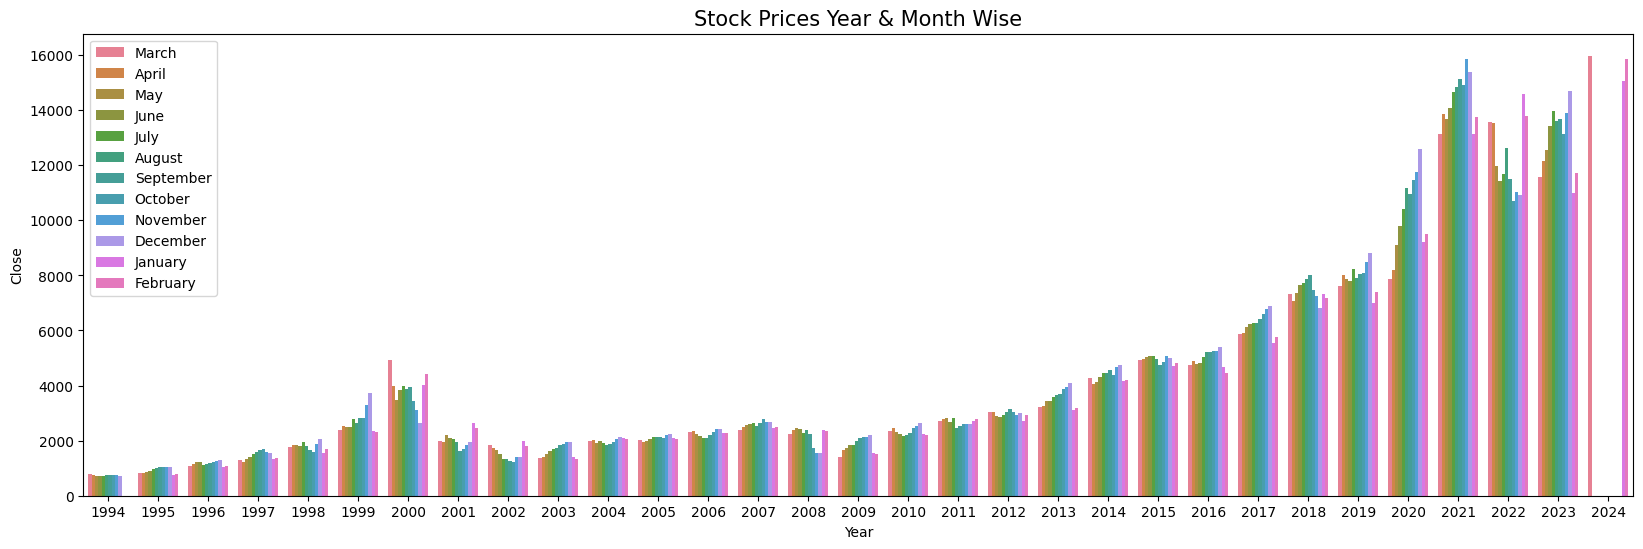

In [ ]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['Quarter'] = monthly_data.index.quarter
fig, ax = plt.subplots(figsize=(20,6))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

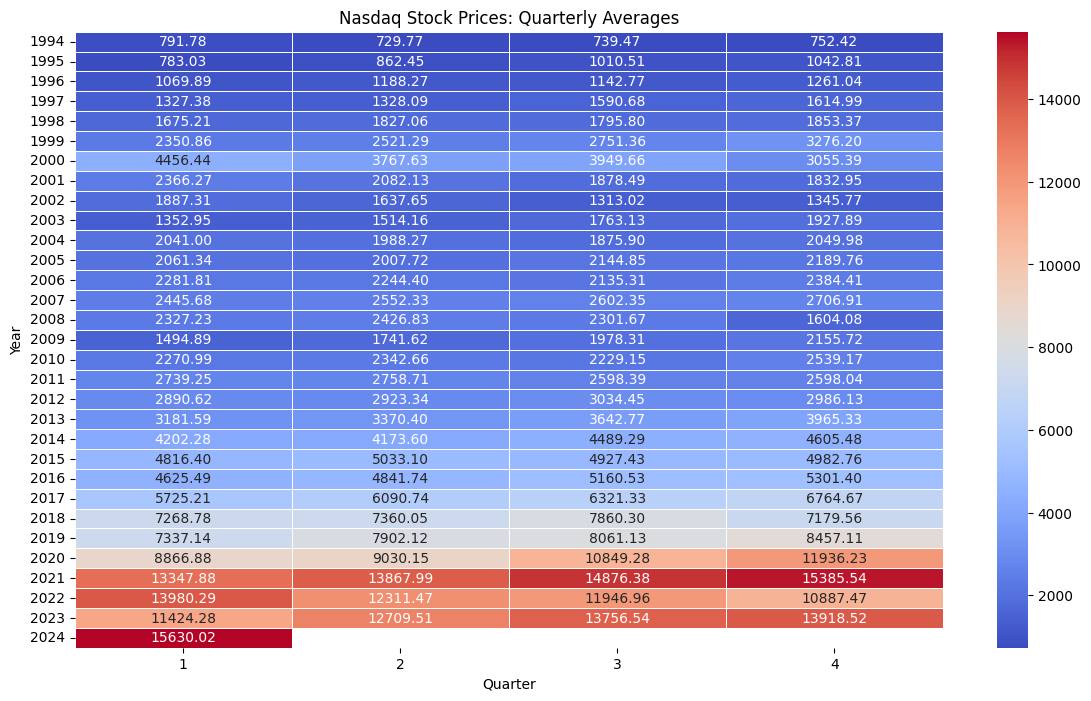

In [ ]:
quarter = monthly_data.groupby(["Year", "Quarter"])["Close"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Nasdaq Stock Prices: Quarterly Averages")
plt.show()

### Data Preparation

#### Target Construction

In [ ]:
# Create Log(Return)
# Calculate logarithmic returns
Nasdaq['Log_Return'] = np.log(Nasdaq['Close'] / Nasdaq['Close'].shift(1))
Nasdaq['Log_Return'].fillna(0, inplace=True)  # Handle NaN values resulting from the shift

#### Covariates construction

In [ ]:
# Calculate Simple Moving Average (SMA)
Nasdaq['SMA_50'] = ta.sma(Nasdaq['Close'], length=50)  # 50-period SMA
Nasdaq['SMA_200'] = ta.sma(Nasdaq['Close'], length=200)  # 200-period SMA

# Calculate Exponential Moving Average (EMA)
Nasdaq['EMA_12'] = ta.ema(Nasdaq['Close'], length=12)  # 12-period EMA
Nasdaq['EMA_26'] = ta.ema(Nasdaq['Close'], length=26)  # 26-period EMA

# Calculate the Stochastic Oscillator components
stoch = ta.stoch(Nasdaq['High'], Nasdaq['Low'], Nasdaq['Close'])
Nasdaq = Nasdaq.join(stoch)

# Calculate Relative Strength Index (RSI)
Nasdaq['RSI_14'] = ta.rsi(Nasdaq['Close'], length=14)  # 14-period RSI

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.macd(Nasdaq['Close'])
Nasdaq = Nasdaq.join(macd)

In [ ]:
Nasdaq['Date'] = pd.to_datetime(Nasdaq['Date'])
Nasdaq.set_index('Date', inplace=True)

In [ ]:
# Handle NaN:
Nasdaq.dropna(inplace=True)

In [ ]:
Nasdaq.shape

(1324, 16)

In [ ]:
dates = Nasdaq.index

In [ ]:
# Calculate split indices
split_idx_train = int(len(Nasdaq) * 0.7)
split_idx_val = int(len(Nasdaq) * 0.9)

# Drop the specified columns and define the features and labels
X_Nasdaq = Nasdaq.drop(['Log_Return'], axis=1)
y_Nasdaq = Nasdaq['Log_Return']  # Log_Return as the target variable

# Ensure that indices are reset before splitting to avoid potential issues
X_Nasdaq.reset_index(drop=True, inplace=True)
y_Nasdaq.reset_index(drop=True, inplace=True)

# Split into training, validation, and testing sets
X_Nasdaq_train = X_Nasdaq.iloc[:split_idx_train, :]
X_Nasdaq_val = X_Nasdaq.iloc[split_idx_train:split_idx_val, :]
X_Nasdaq_test = X_Nasdaq.iloc[split_idx_val:, :]

y_Nasdaq_train = y_Nasdaq.iloc[:split_idx_train]
y_Nasdaq_val = y_Nasdaq.iloc[split_idx_train:split_idx_val]
y_Nasdaq_test = y_Nasdaq.iloc[split_idx_val:]

In [ ]:
Nasdaq_dates_test = dates[split_idx_val:]

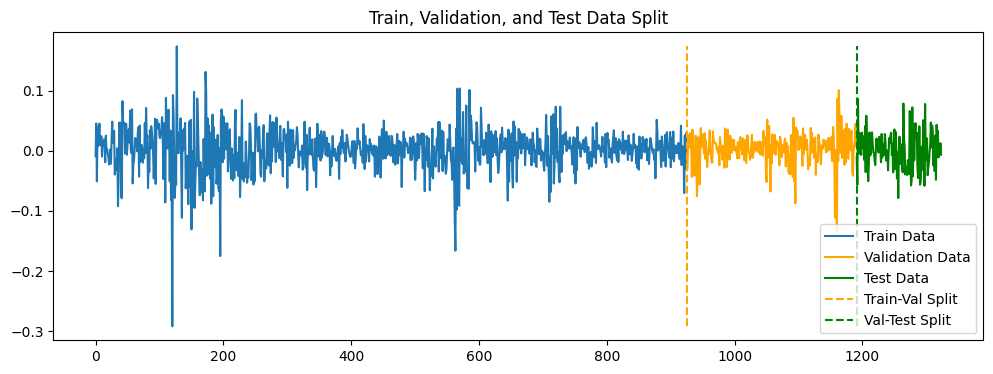

In [ ]:
# Indices for plotting
x_train = np.arange(len(y_Nasdaq_train))
x_val = np.arange(len(y_Nasdaq_train), len(y_Nasdaq_train) + len(y_Nasdaq_val))
x_test = np.arange(len(y_Nasdaq_train) + len(y_Nasdaq_val), len(y_Nasdaq))

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(x_train, y_Nasdaq_train, label="Train Data")
plt.plot(x_val, y_Nasdaq_val, color='orange', label="Validation Data")
plt.plot(x_test, y_Nasdaq_test, color='green', label="Test Data")
plt.vlines(len(y_Nasdaq_train), ymin=min(y_Nasdaq.min(), y_Nasdaq.min(), y_Nasdaq.min()), ymax=max(y_Nasdaq.max(), y_Nasdaq.max(), y_Nasdaq.max()), label='Train-Val Split', linestyles='dashed', colors='orange')
plt.vlines(len(y_Nasdaq_train) + len(y_Nasdaq_val), ymin=min(y_Nasdaq.min(), y_Nasdaq.min(), y_Nasdaq.min()), ymax=max(y_Nasdaq.max(), y_Nasdaq.max(), y_Nasdaq.max()), label='Val-Test Split', linestyles='dashed', colors='green')
plt.legend()
plt.title("Train, Validation, and Test Data Split")
plt.show()

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import power_transform

# Fit the transformer on the training data and transform it
X_Nasdaq_train_transformed = power_transform(X_Nasdaq_train.to_numpy(), method='yeo-johnson')

# Transform the validation data using the same transformer
X_Nasdaq_val_transformed = power_transform(X_Nasdaq_val.to_numpy(), method='yeo-johnson')

# Transform the test data using the same transformer
X_Nasdaq_test_transformed = power_transform(X_Nasdaq_test.to_numpy(), method='yeo-johnson')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_Nasdaq_train_scaled = scaler.fit_transform(X_Nasdaq_train_transformed)

# Transform the val data using the same scaler
X_Nasdaq_val_scaled = scaler.transform(X_Nasdaq_val_transformed)

# Transform the test data using the same scaler
X_Nasdaq_test_scaled = scaler.transform(X_Nasdaq_test_transformed)

In [ ]:
print(X_Nasdaq_train_scaled.shape)
print(X_Nasdaq_val_scaled.shape)
print(X_Nasdaq_test_scaled.shape)

(926, 15)
(265, 15)
(133, 15)


### Models

#### Loss function: RMSE

##### RNNs

In [ ]:
!ls "/content/drive/MyDrive/ML_project/Colab"

 Amazon.ipynb   Cac.ipynb   Master.ipynb      Nasdaq.ipynb   __pycache__      Sp500.ipynb
 anns.py        IBM.ipynb   Microsoft.ipynb  'old files'    'RMSE all(RNN)'


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ML_project/Colab')
from anns import EnhancedSignAgreementLoss, rnns, create_sequences_rnns, SimpleRNN, RMSELoss

In [ ]:
# Ensure y_Nasdaq_train and y_test are numpy arrays
y_Nasdaq_train = y_Nasdaq_train.to_numpy() if isinstance(y_Nasdaq_train, pd.Series) else y_Nasdaq_train
y_Nasdaq_val = y_Nasdaq_val.to_numpy() if isinstance(y_Nasdaq_val, pd.Series) else y_Nasdaq_val
y_Nasdaq_test = y_Nasdaq_test.to_numpy() if isinstance(y_Nasdaq_test, pd.Series) else y_Nasdaq_test

# Create sequences
time_steps = 10
X_Nasdaq_train_seq, y_Nasdaq_train_seq = create_sequences_rnns(X_Nasdaq_train_scaled, y_Nasdaq_train, time_steps)
X_Nasdaq_val_seq, y_Nasdaq_val_seq = create_sequences_rnns(X_Nasdaq_val_scaled, y_Nasdaq_val, time_steps)
X_Nasdaq_test_seq, y_Nasdaq_test_seq = create_sequences_rnns(X_Nasdaq_test_scaled, y_Nasdaq_test, time_steps)

X_Nasdaq_train_tensor = torch.tensor(X_Nasdaq_train_seq, dtype=torch.float32)
y_Nasdaq_train_tensor = torch.tensor(y_Nasdaq_train_seq, dtype=torch.float32)
X_Nasdaq_val_tensor = torch.tensor(X_Nasdaq_val_seq, dtype=torch.float32)
y_Nasdaq_val_tensor = torch.tensor(y_Nasdaq_val_seq, dtype=torch.float32)
X_Nasdaq_test_tensor = torch.tensor(X_Nasdaq_test_seq, dtype=torch.float32)
y_Nasdaq_test_tensor = torch.tensor(y_Nasdaq_test_seq, dtype=torch.float32)

# Prepare data loaders
Nasdaq_train_dataset = TensorDataset(X_Nasdaq_train_tensor, y_Nasdaq_train_tensor)
Nasdaq_train_loader = DataLoader(dataset=Nasdaq_train_dataset, batch_size=32, shuffle=True)
Nasdaq_val_dataset = TensorDataset(X_Nasdaq_val_tensor, y_Nasdaq_val_tensor)
Nasdaq_val_loader = DataLoader(dataset=Nasdaq_val_dataset, batch_size=32, shuffle=False)

# Prepare data for prediction
Nasdaq_predict_dataset = TensorDataset(X_Nasdaq_test_tensor, y_Nasdaq_test_tensor)
Nasdaq_predict_loader = DataLoader(Nasdaq_predict_dataset, batch_size=32, shuffle=False)

In [ ]:
X_Nasdaq_train_tensor.shape

torch.Size([916, 10, 15])

In [ ]:
# Set seed for NumPy
np.random.seed(20)

# Set seed for PyTorch
torch.manual_seed(20)

In [ ]:
# Initialize the RNN model
Nasdaq_rnns_rmse = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(Nasdaq_rnns_rmse.parameters(), lr=0.001)
loss_function = RMSELoss()
epochs = 100

best_model_state, best_val_loss = rnns(Nasdaq_rnns_rmse, Nasdaq_train_loader, Nasdaq_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 0.03826198726892471, Val Loss: 0.07378683239221573
Epoch 11, Train Loss: 0.03296466916799545, Val Loss: 0.04435846582055092
Epoch 21, Train Loss: 0.027114082127809525, Val Loss: 0.03801862522959709
Epoch 31, Train Loss: 0.030315741896629333, Val Loss: 0.036299094557762146
Epoch 41, Train Loss: 0.046314459294080734, Val Loss: 0.03472653403878212
Epoch 51, Train Loss: 0.034378644078969955, Val Loss: 0.035789795219898224
Epoch 61, Train Loss: 0.026545340195298195, Val Loss: 0.035844169557094574
Epoch 71, Train Loss: 0.029530979692935944, Val Loss: 0.031950317323207855
Epoch 81, Train Loss: 0.02570209465920925, Val Loss: 0.03462901711463928
Epoch 91, Train Loss: 0.03274226188659668, Val Loss: 0.034331243485212326


In [ ]:
best_val_loss

tensor(0.0317)

In [ ]:
Nasdaq_rnns_rmse.load_state_dict(best_model_state)
Nasdaq_rnns_rmse.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
Nasdaq_predictions = []
Nasdaq_actuals = []

with torch.no_grad():
    for inputs, labels in Nasdaq_predict_loader:
        outputs = Nasdaq_rnns_rmse(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        Nasdaq_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        Nasdaq_actuals.extend(labels.cpu().numpy())

In [ ]:
Nasdaq_rnns_rmse_predictions = np.array(Nasdaq_predictions)
Nasdaq_rnns_rmse_actuals = np.array(Nasdaq_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming Nasdaq_rnns_rmse_predictions and Nasdaq_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
Nasdaq_rnns_rmse_predicted_labels = (Nasdaq_rnns_rmse_predictions >= 0).astype(int)
Nasdaq_rnns_rmse_actual_labels = (Nasdaq_rnns_rmse_actuals >= 0).astype(int)

# Calculate classifier metrics
Nasdaq_rnns_rmse_accuracy = accuracy_score(Nasdaq_rnns_rmse_actual_labels, Nasdaq_rnns_rmse_predicted_labels)
Nasdaq_rnns_rmse_precision = precision_score(Nasdaq_rnns_rmse_actual_labels, Nasdaq_rnns_rmse_predicted_labels)
Nasdaq_rnns_rmse_recall = recall_score(Nasdaq_rnns_rmse_actual_labels, Nasdaq_rnns_rmse_predicted_labels)
Nasdaq_rnns_rmse_f1 = f1_score(Nasdaq_rnns_rmse_actual_labels, Nasdaq_rnns_rmse_predicted_labels)

# Print the classification metrics
print("Accuracy:", Nasdaq_rnns_rmse_accuracy)
print("Precision:", Nasdaq_rnns_rmse_precision)
print("Recall:", Nasdaq_rnns_rmse_recall)
print("F1 Score:", Nasdaq_rnns_rmse_f1)

Accuracy: 0.6016260162601627
Precision: 0.5857142857142857
Recall: 0.6721311475409836
F1 Score: 0.6259541984732824


###### Plots

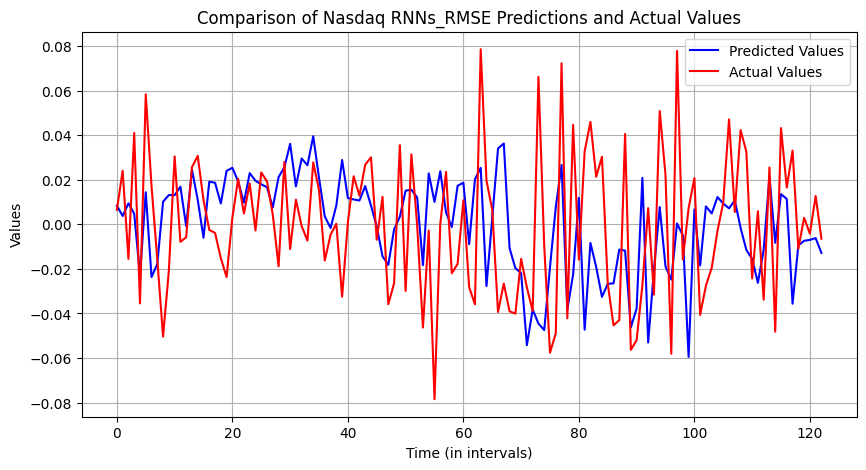

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(Nasdaq_rnns_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(Nasdaq_rnns_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of Nasdaq RNNs_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

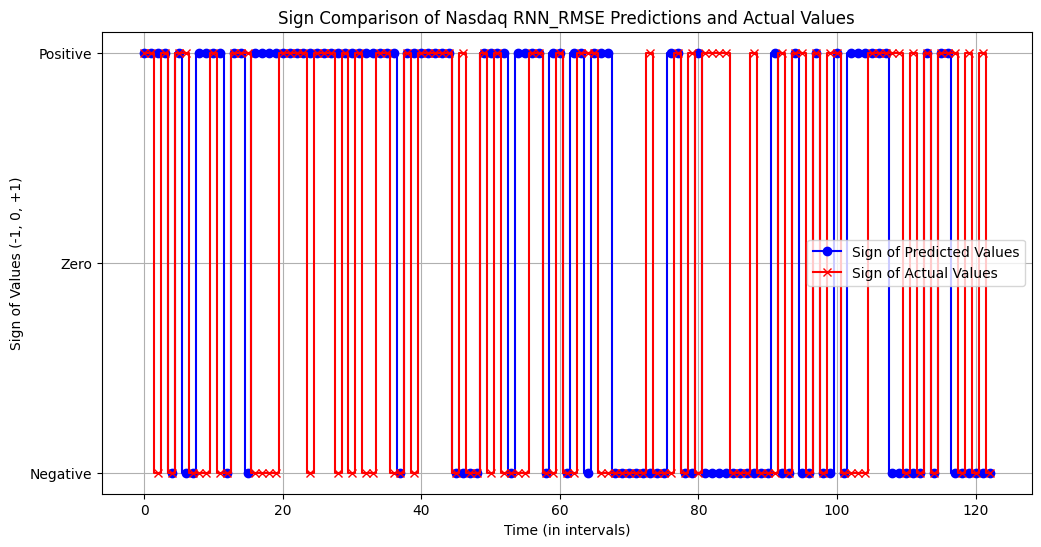

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(Nasdaq_rnns_rmse_predictions)
signs_actuals_rnn = np.sign(Nasdaq_rnns_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of Nasdaq RNN_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
X_Nasdaq_train_anfis = torch.tensor(X_Nasdaq_train_scaled, dtype=torch.float32)
y_Nasdaq_train_anfis = torch.tensor(y_Nasdaq_train, dtype=torch.float32)
X_Nasdaq_val_anfis = torch.tensor(X_Nasdaq_val_scaled, dtype=torch.float32)
y_Nasdaq_val_anfis = torch.tensor(y_Nasdaq_val, dtype=torch.float32)
X_Nasdaq_test_anfis = torch.tensor(X_Nasdaq_test_scaled, dtype=torch.float32)
y_Nasdaq_test_anfis = torch.tensor(y_Nasdaq_test, dtype=torch.float32)

In [ ]:
X_Nasdaq_train_anfis.shape

torch.Size([926, 15])

In [ ]:
from anns import ANFIS_RMSE
input_dim = X_Nasdaq_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.005

# Initialize the ANFIS model
Nasdaq_anfis_rmse = ANFIS_RMSE(functions=functions, input_dim=input_dim)

# Train the model
Nasdaq_anfis_rmse.fit(X_Nasdaq_train_anfis, y_Nasdaq_train_anfis
                      , X_Nasdaq_val_anfis, y_Nasdaq_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
Nasdaq_anfis_rmse_predictions = Nasdaq_anfis_rmse.predict(X_Nasdaq_test_anfis)

Epoch 1/100, Train Loss: 0.0012, Validation Loss: 0.0008
Epoch 11/100, Train Loss: 0.0011, Validation Loss: 0.0007
Epoch 21/100, Train Loss: 0.0011, Validation Loss: 0.0006
Epoch 31/100, Train Loss: 0.0010, Validation Loss: 0.0007
Epoch 41/100, Train Loss: 0.0010, Validation Loss: 0.0007
Epoch 51/100, Train Loss: 0.0010, Validation Loss: 0.0007
Epoch 61/100, Train Loss: 0.0010, Validation Loss: 0.0006
Epoch 71/100, Train Loss: 0.0009, Validation Loss: 0.0007
Epoch 81/100, Train Loss: 0.0009, Validation Loss: 0.0007
Epoch 91/100, Train Loss: 0.0008, Validation Loss: 0.0007
Best Validation Loss: 0.0006


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
Nasdaq_anfis_rmse_predictions = Nasdaq_anfis_rmse_predictions.detach().cpu().numpy()
Nasdaq_anfis_rmse_actuals = y_Nasdaq_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
# Positive sign (including zero for simplicity in binary classification) will be 1
# Negative sign will be 0
def sign_classify(values):
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(Nasdaq_anfis_rmse_predictions)
actual_signs = sign_classify(Nasdaq_anfis_rmse_actuals)

# Calculate metrics directly comparing predicted and actual signs
Nasdaq_anfis_rmse_accuracy = accuracy_score(actual_signs, predicted_signs)
Nasdaq_anfis_rmse_precision = precision_score(actual_signs, predicted_signs)
Nasdaq_anfis_rmse_recall = recall_score(actual_signs, predicted_signs)
Nasdaq_anfis_rmse_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", Nasdaq_anfis_rmse_accuracy)
print("Precision:", Nasdaq_anfis_rmse_precision)
print("Recall:", Nasdaq_anfis_rmse_recall)
print("F1 Score:", Nasdaq_anfis_rmse_f1)

Accuracy: 0.8571428571428571
Precision: 0.8243243243243243
Recall: 0.9104477611940298
F1 Score: 0.8652482269503546


###### Plots

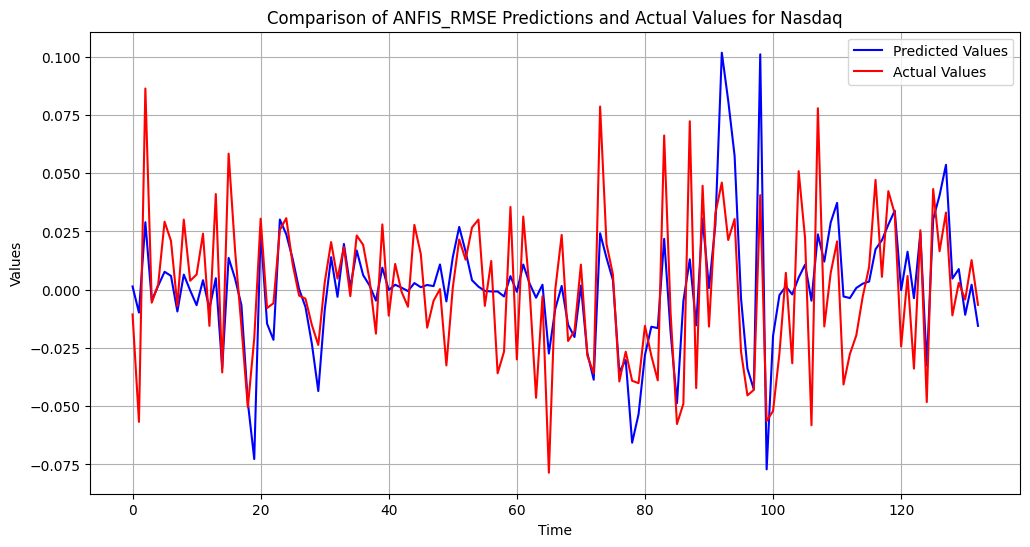

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(Nasdaq_anfis_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(Nasdaq_anfis_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_RMSE Predictions and Actual Values for Nasdaq')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

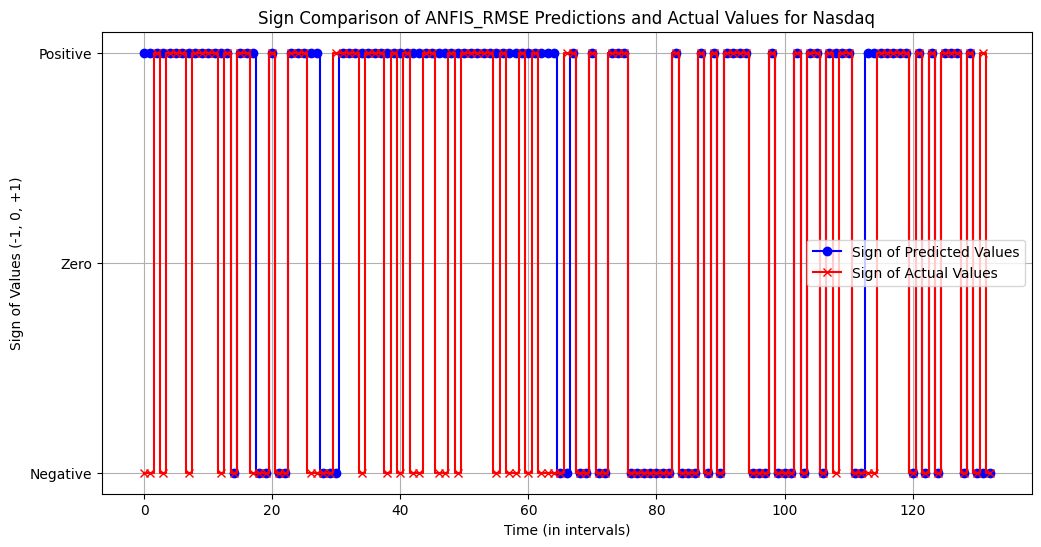

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(Nasdaq_anfis_rmse_predictions)
signs_actuals = np.sign(Nasdaq_anfis_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_RMSE Predictions and Actual Values for Nasdaq')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

#### Custom loss function

##### RNNs

In [ ]:
from anns import EnhancedSignAgreementLoss
# Initialize the RNN model
Nasdaq_rnns_custom = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(Nasdaq_rnns_custom.parameters(), lr=0.001)
loss_function = EnhancedSignAgreementLoss(loss_penalty=5000)
epochs = 100

best_model_state, best_val_loss = rnns(Nasdaq_rnns_custom, Nasdaq_train_loader, Nasdaq_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 2000.0035400390625, Val Loss: 2531.508544921875
Epoch 11, Train Loss: 2750.00146484375, Val Loss: 2413.686767578125
Epoch 21, Train Loss: 3500.001220703125, Val Loss: 2511.341796875
Epoch 31, Train Loss: 3250.00146484375, Val Loss: 2707.91455078125
Epoch 41, Train Loss: 3250.00146484375, Val Loss: 2510.71142578125
Epoch 51, Train Loss: 3250.00146484375, Val Loss: 2414.31591796875
Epoch 61, Train Loss: 2750.001953125, Val Loss: 2610.25830078125
Epoch 71, Train Loss: 2750.00048828125, Val Loss: 2587.576416015625
Epoch 81, Train Loss: 2500.00048828125, Val Loss: 2453.378173828125
Epoch 91, Train Loss: 2500.00244140625, Val Loss: 2391.634521484375


In [ ]:
best_val_loss

tensor(2137.0979)

In [ ]:
Nasdaq_rnns_custom.load_state_dict(best_model_state)
Nasdaq_rnns_custom.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
Nasdaq_predictions = []
Nasdaq_actuals = []

with torch.no_grad():
    for inputs, labels in Nasdaq_predict_loader:
        outputs = Nasdaq_rnns_custom(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        Nasdaq_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        Nasdaq_actuals.extend(labels.cpu().numpy())

In [ ]:
Nasdaq_rnns_custom_predictions = np.array(Nasdaq_predictions)
Nasdaq_rnns_custom_actuals = np.array(Nasdaq_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming Nasdaq_rnns_rmse_predictions and Nasdaq_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
Nasdaq_rnns_custom_predicted_labels = (Nasdaq_rnns_custom_predictions >= 0).astype(int)
Nasdaq_rnns_custom_actual_labels = (Nasdaq_rnns_custom_actuals >= 0).astype(int)

# Calculate classifier metrics
Nasdaq_rnns_custom_accuracy = accuracy_score(Nasdaq_rnns_custom_actual_labels, Nasdaq_rnns_custom_predicted_labels)
Nasdaq_rnns_custom_precision = precision_score(Nasdaq_rnns_custom_actual_labels, Nasdaq_rnns_custom_predicted_labels)
Nasdaq_rnns_custom_recall = recall_score(Nasdaq_rnns_custom_actual_labels, Nasdaq_rnns_custom_predicted_labels)
Nasdaq_rnns_custom_f1 = f1_score(Nasdaq_rnns_custom_actual_labels, Nasdaq_rnns_custom_predicted_labels)

# Print the classification metrics
print("Accuracy:", Nasdaq_rnns_custom_accuracy)
print("Precision:", Nasdaq_rnns_custom_precision)
print("Recall:", Nasdaq_rnns_custom_recall)
print("F1 Score:", Nasdaq_rnns_custom_f1)

Accuracy: 0.5609756097560976
Precision: 0.559322033898305
Recall: 0.5409836065573771
F1 Score: 0.55


###### Plots

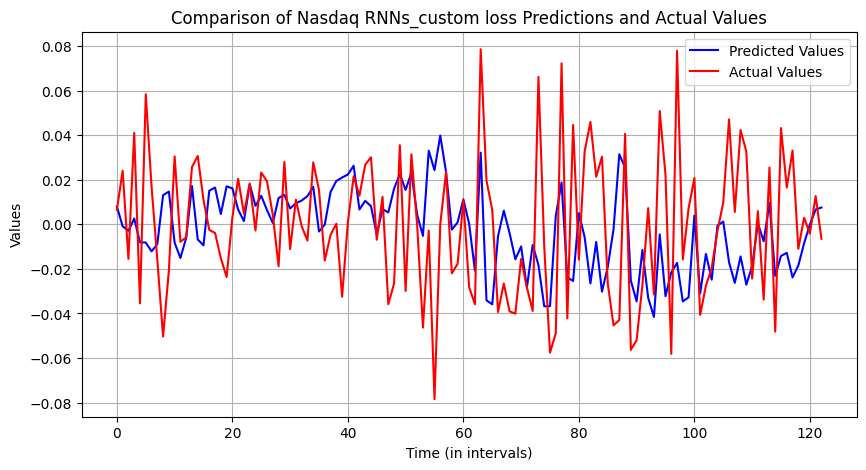

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(Nasdaq_rnns_custom_predictions, label='Predicted Values', color='blue')
plt.plot(Nasdaq_rnns_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of Nasdaq RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

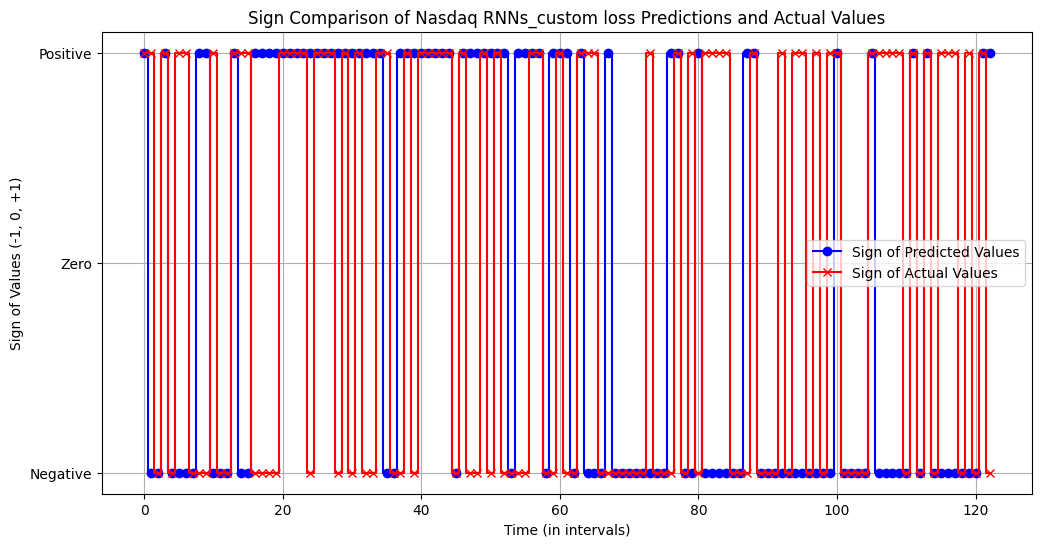

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(Nasdaq_rnns_custom_predictions)
signs_actuals_rnn = np.sign(Nasdaq_rnns_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of Nasdaq RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
from anns import ANFIS_CustomLoss

input_dim = X_Nasdaq_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.005

# Initialize the ANFIS model
Nasdaq_anfis_custom = ANFIS_CustomLoss(functions=functions, input_dim=input_dim, loss_penalty=10000)

# Train the model
Nasdaq_anfis_custom.fit(X_Nasdaq_train_anfis, y_Nasdaq_train_anfis
                      , X_Nasdaq_val_anfis, y_Nasdaq_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
Nasdaq_anfis_custom_predictions = Nasdaq_anfis_custom.predict(X_Nasdaq_test_anfis)

Epoch 1/100, Train Loss: 5345.5766, Val Loss: 3886.7930
Epoch 11/100, Train Loss: 3963.2839, Val Loss: 4792.4534
Epoch 21/100, Train Loss: 3488.1219, Val Loss: 2981.1326
Epoch 31/100, Train Loss: 3250.5409, Val Loss: 3433.9629
Epoch 41/100, Train Loss: 3164.1478, Val Loss: 2716.9816
Epoch 51/100, Train Loss: 3174.9468, Val Loss: 2754.7176
Epoch 61/100, Train Loss: 2559.3960, Val Loss: 2603.7741
Epoch 71/100, Train Loss: 2224.6227, Val Loss: 1924.5288
Epoch 81/100, Train Loss: 1706.2641, Val Loss: 1773.5853
Epoch 91/100, Train Loss: 1598.2727, Val Loss: 1773.5853
Best Validation Loss: 1622.6418


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
Nasdaq_anfis_custom_predictions = Nasdaq_anfis_custom_predictions.detach().cpu().numpy()
Nasdaq_anfis_custom_actuals = y_Nasdaq_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
def sign_classify(values):
    # Convert positive and zero values to 1, and negative values to 0
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(Nasdaq_anfis_custom_predictions)
actual_signs = sign_classify(Nasdaq_anfis_custom_actuals)

# Calculate metrics directly using predicted and actual signs
Nasdaq_anfis_custom_accuracy = accuracy_score(actual_signs, predicted_signs)
Nasdaq_anfis_custom_precision = precision_score(actual_signs, predicted_signs)
Nasdaq_anfis_custom_recall = recall_score(actual_signs, predicted_signs)
Nasdaq_anfis_custom_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", Nasdaq_anfis_custom_accuracy)
print("Precision:", Nasdaq_anfis_custom_precision)
print("Recall:", Nasdaq_anfis_custom_recall)
print("F1 Score:", Nasdaq_anfis_custom_f1)

Accuracy: 0.9097744360902256
Precision: 0.8985507246376812
Recall: 0.9253731343283582
F1 Score: 0.9117647058823529


###### Plots

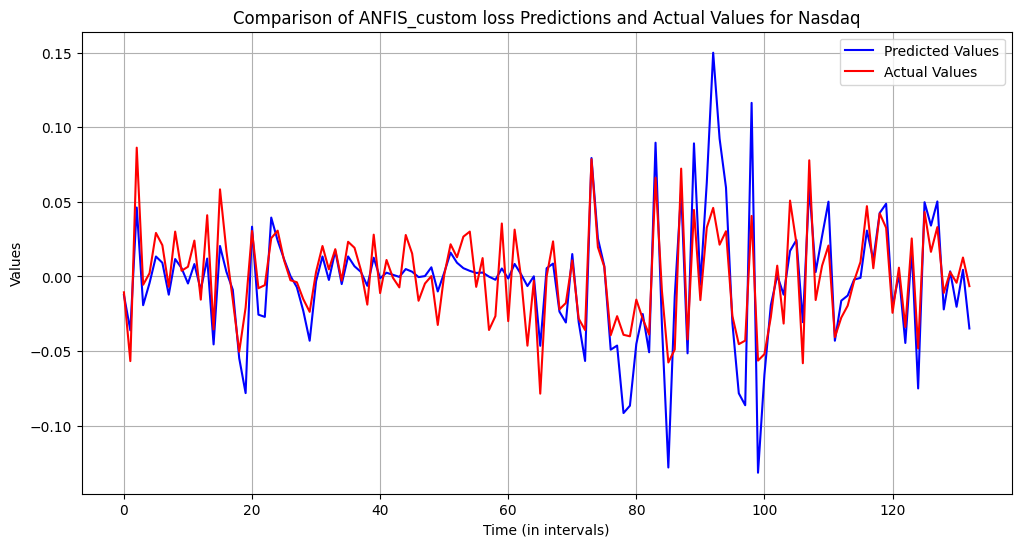

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(Nasdaq_anfis_custom_predictions, label='Predicted Values', color='blue')
plt.plot(Nasdaq_anfis_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_custom loss Predictions and Actual Values for Nasdaq')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

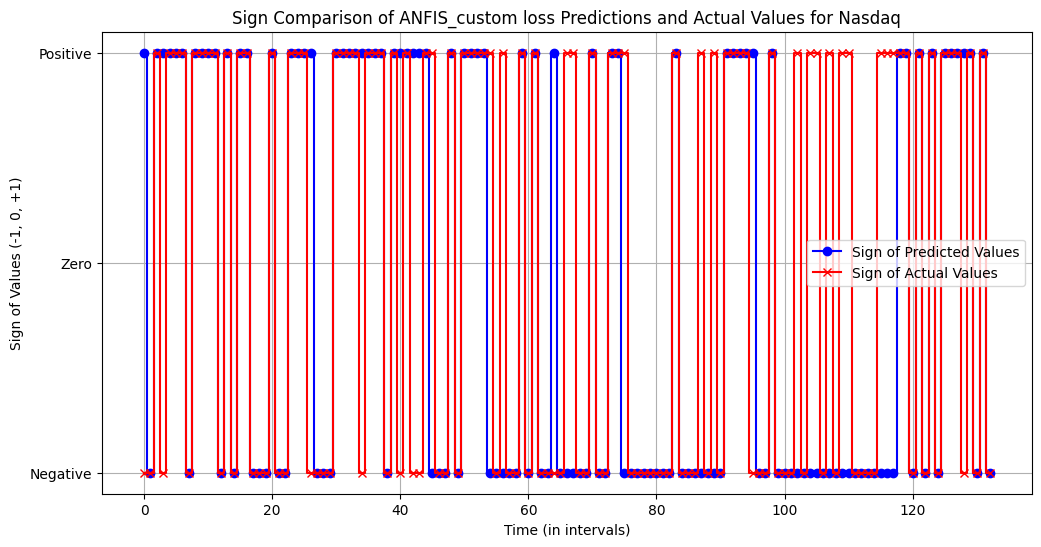

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(Nasdaq_anfis_custom_predictions)
signs_actuals = np.sign(Nasdaq_anfis_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_custom loss Predictions and Actual Values for Nasdaq')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()